In [60]:
!pip install tensorflow_quantum

In [61]:
import tensorflow as tf
import tensorflow_quantum as tfq


import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [62]:
(x_train_o, y_train_o), (x_test_o, y_test_o) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train_o, x_test_o = x_train_o[..., np.newaxis]/255.0, x_test_o[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train_o))
print("Number of original test examples:", len(x_test_o))

Number of original training examples: 60000
Number of original test examples: 10000


Number of filtered training examples: 12665
Number of filtered test examples: 2115
True


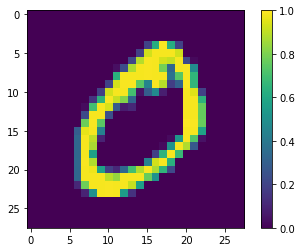

True


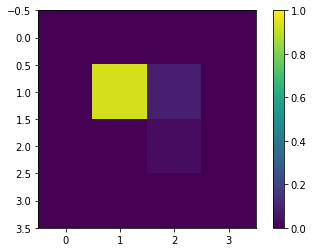

In [63]:
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y
x_train, y_train = filter_01(x_train_o, y_train_o)
x_test, y_test = filter_01(x_test_o, y_test_o)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()
plt.show()

x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [64]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass

    num_0 = sum(1 for value in mapping.values() if True in value)
    num_1 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 0s: ", num_0)
    print("Number of 1s: ", num_1)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))

    return np.array(new_x), np.array(new_y)

x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 7100
Number of 0s:  5032
Number of 1s:  2176
Number of contradictory images:  108

Initial number of examples:  12665
Remaining non-contradictory examples:  8961


In [65]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 126
Number of 0s:  121
Number of 1s:  38
Number of contradictory images:  33

Initial number of examples:  8961
Remaining non-contradictory examples:  1550


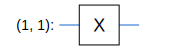

In [66]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]
SVGCircuit(x_train_circ[0])

In [67]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

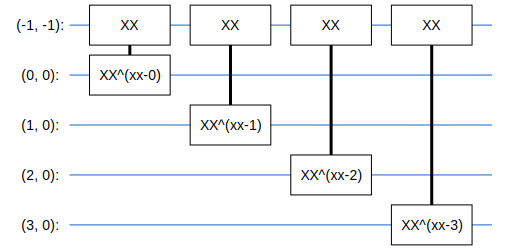

In [68]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [69]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

model_circuit, model_readout = create_quantum_model()

# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_2 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [70]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
281/281 [==============================] - 511s 2s/step - loss: 0.7387 - hinge_accuracy: 0.7007 - val_loss: 0.3666 - val_hinge_accuracy: 0.8438
Epoch 2/3
281/281 [==============================] - 514s 2s/step - loss: 0.4618 - hinge_accuracy: 0.7777 - val_loss: 0.3131 - val_hinge_accuracy: 0.8438
Epoch 3/3
67/67 [==============================] - 17s 257ms/step - loss: 0.3077 - hinge_accuracy: 0.8438
